# Starbucks Promotional Offer A/B Testing Analysis

**Author:** Rohini Vishwanathan  
**Date:** January 2025

## Business Context

Starbucks sends promotional offers to customers through their mobile app:
- **BOGO (Buy One Get One Free):** Spend X, get X back as reward
- **Discount:** Get a percentage or dollar amount off
- **Informational:** Just an advertisement, no actual reward

**Questions we're answering:**
1. Do promotional offers actually increase customer spending?
2. Which offer type (BOGO vs Discount) performs best?
3. Which customer segments respond best to offers?

##Import Libraries

In [ ]:
# Core data manipulation
import pandas as pd              # DataFrames - think Excel for Python
import numpy as np               # Numerical operations

# Visualization
import matplotlib.pyplot as plt  # Basic plotting
import seaborn as sns            # Statistical visualizations

# Statistical testing - this is the A/B testing magic
from scipy import stats
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu, kruskal

# For confidence intervals and power analysis
from statsmodels.stats.proportion import proportions_ztest, proportion_confint
from statsmodels.stats.power import TTestIndPower

# Utility
import ast                       # To parse string dictionaries
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)

# Plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')

print("✓ Libraries loaded successfully!")

✓ Libraries loaded successfully!


##Loading the data

In [ ]:
# Load the three datasets
portfolio = pd.read_csv('portfolio.csv')
profile = pd.read_csv('profile.csv')
transcript = pd.read_csv('transcript.csv')

print(f"Portfolio: {portfolio.shape[0]} offers")
print(f"Profile: {profile.shape[0]} customers")
print(f"Transcript: {transcript.shape[0]} events")

Portfolio: 10 offers
Profile: 17000 customers
Transcript: 306534 events


##Explore Portfolia Data

In [ ]:
# What offers does Starbucks have
print("=" * 60)
print("OFFER PORTFOLIO")
print("=" * 60)
display(portfolio)

print("\nOffer Types Summary:")
print("-" * 40)
print(f"BOGO offers: {len(portfolio[portfolio['offer_type'] == 'bogo'])}")
print(f"Discount offers: {len(portfolio[portfolio['offer_type'] == 'discount'])}")
print(f"Informational offers: {len(portfolio[portfolio['offer_type'] == 'informational'])}")

OFFER PORTFOLIO


,Unnamed: 0,reward,channels,difficulty,duration,offer_type,id
0,0,10,"['email', 'mobile', 'social']",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,1,10,"['web', 'email', 'mobile', 'social']",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,2,0,"['web', 'email', 'mobile']",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,3,5,"['web', 'email', 'mobile']",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,4,5,"['web', 'email']",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,5,3,"['web', 'email', 'mobile', 'social']",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,6,2,"['web', 'email', 'mobile', 'social']",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,7,0,"['email', 'mobile', 'social']",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,8,5,"['web', 'email', 'mobile', 'social']",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,9,2,"['web', 'email', 'mobile']",10,7,discount,2906b810c7d4411798c6938adc9daaa5



Offer Types Summary:
----------------------------------------
BOGO offers: 4
Discount offers: 4
Informational offers: 2


##Explore Customer Data

In [ ]:
# Check customer data
print("=" * 60)
print("CUSTOMER PROFILE DATA")
print("=" * 60)
print(f"\nShape: {profile.shape}")
print(f"\nMissing Values:")
print(profile.isnull().sum())

# Check the age = 118 issue
print(f"\nCustomers with age = 118: {len(profile[profile['age'] == 118])}")
print(f"Percentage: {len(profile[profile['age'] == 118]) / len(profile) * 100:.1f}%")
print("\n⚠️ Age = 118 is a placeholder for missing data!")

CUSTOMER PROFILE DATA

Shape: (17000, 6)

Missing Values:
Unnamed: 0             0
gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

Customers with age = 118: 2175
Percentage: 12.8%

⚠️ Age = 118 is a placeholder for missing data!


##Clean Profile Data

In [ ]:
# Remove customers with incomplete profiles (age = 118)
profile_clean = profile[profile['age'] != 118].copy()

print(f"Original customers: {len(profile)}")
print(f"After removing incomplete profiles: {len(profile_clean)}")
print(f"Removed: {len(profile) - len(profile_clean)} ({(len(profile) - len(profile_clean)) / len(profile) * 100:.1f}%)")

Original customers: 17000
After removing incomplete profiles: 14825
Removed: 2175 (12.8%)


##Visualize Customer Demographics

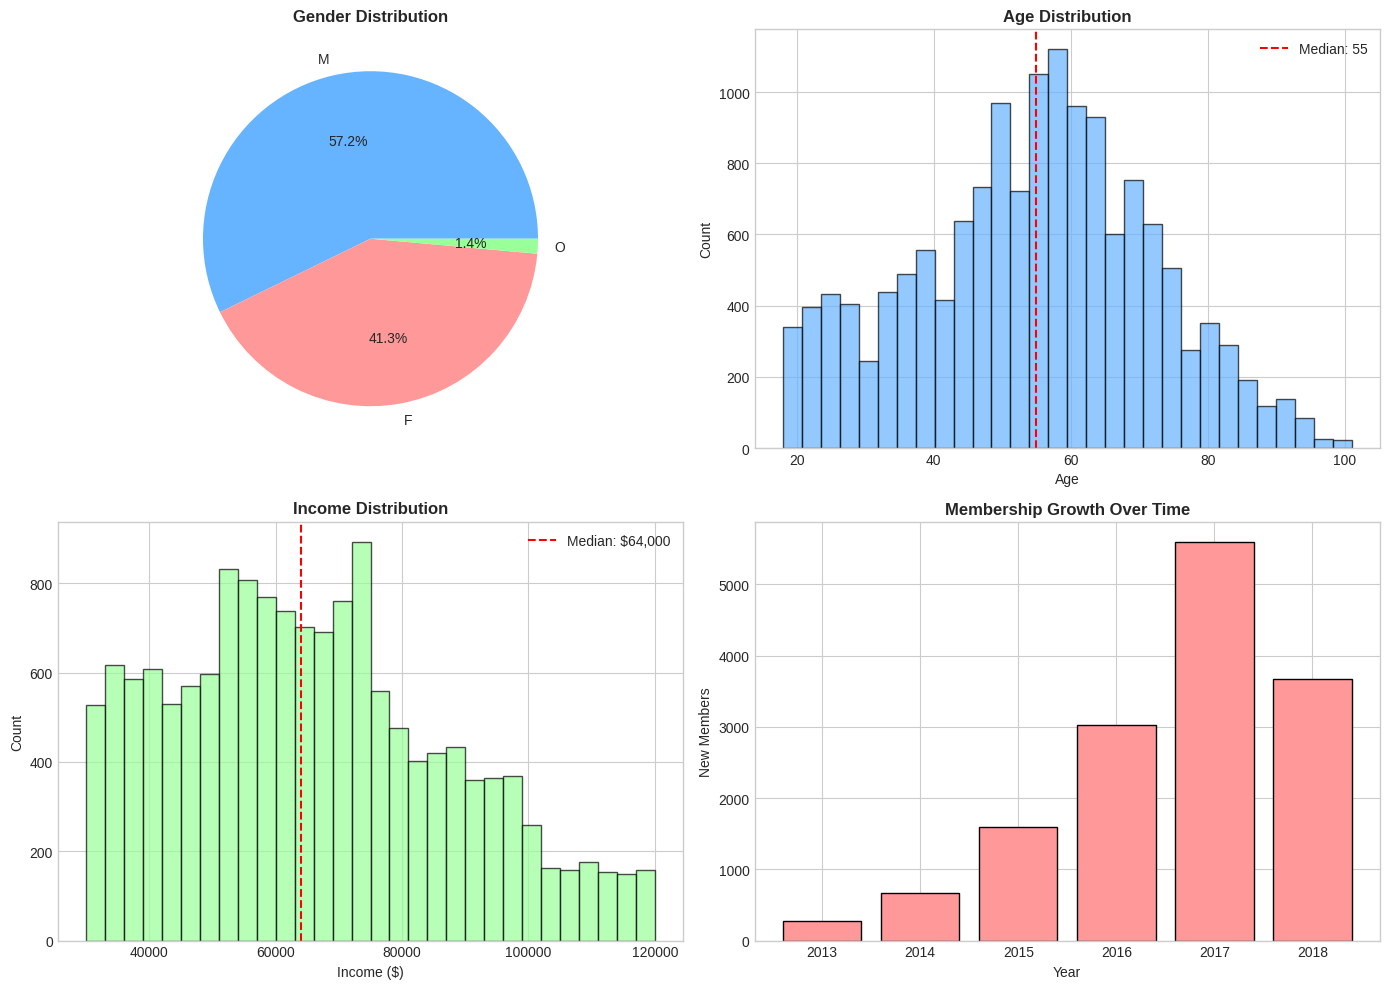


Customer Demographics Summary:
----------------------------------------
Median Age: 55 years
Median Income: $64,000


In [ ]:
# Customer demographics visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Gender distribution
ax1 = axes[0, 0]
gender_counts = profile_clean['gender'].value_counts()
ax1.pie(gender_counts.values, labels=gender_counts.index, autopct='%1.1f%%',
        colors=['#66b3ff', '#ff9999', '#99ff99'])
ax1.set_title('Gender Distribution', fontsize=12, fontweight='bold')

# Age distribution
ax2 = axes[0, 1]
ax2.hist(profile_clean['age'], bins=30, edgecolor='black', alpha=0.7, color='#66b3ff')
ax2.axvline(profile_clean['age'].median(), color='red', linestyle='--',
            label=f'Median: {profile_clean["age"].median():.0f}')
ax2.set_xlabel('Age')
ax2.set_ylabel('Count')
ax2.set_title('Age Distribution', fontsize=12, fontweight='bold')
ax2.legend()

# Income distribution
ax3 = axes[1, 0]
ax3.hist(profile_clean['income'], bins=30, edgecolor='black', alpha=0.7, color='#99ff99')
ax3.axvline(profile_clean['income'].median(), color='red', linestyle='--',
            label=f'Median: ${profile_clean["income"].median():,.0f}')
ax3.set_xlabel('Income ($)')
ax3.set_ylabel('Count')
ax3.set_title('Income Distribution', fontsize=12, fontweight='bold')
ax3.legend()

# Membership over time
ax4 = axes[1, 1]
profile_clean['became_member_on'] = pd.to_datetime(profile_clean['became_member_on'], format='%Y%m%d')
profile_clean['member_year'] = profile_clean['became_member_on'].dt.year
member_by_year = profile_clean['member_year'].value_counts().sort_index()
ax4.bar(member_by_year.index, member_by_year.values, color='#ff9999', edgecolor='black')
ax4.set_xlabel('Year')
ax4.set_ylabel('New Members')
ax4.set_title('Membership Growth Over Time', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nCustomer Demographics Summary:")
print("-" * 40)
print(f"Median Age: {profile_clean['age'].median():.0f} years")
print(f"Median Income: ${profile_clean['income'].median():,.0f}")

##Explore Transcript Data

In [ ]:
# Event log exploration
print("=" * 60)
print("TRANSCRIPT (EVENT LOG) DATA")
print("=" * 60)
print(f"\nShape: {transcript.shape}")
print(f"\nEvent Types:")
print(transcript['event'].value_counts())

print(f"\nTime range: {transcript['time'].min()} to {transcript['time'].max()} hours")
print(f"That's {transcript['time'].max() / 24:.0f} days of data")

TRANSCRIPT (EVENT LOG) DATA

Shape: (306534, 5)

Event Types:
event
transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: count, dtype: int64

Time range: 0 to 714 hours
That's 30 days of data


##Parse the Value Column

In [ ]:
# The 'value' column contains nested dictionaries as strings
# We need to parse them to extract offer_id and transaction amounts

def parse_value(value_str):
    """
    Parse the string representation of a dictionary in the 'value' column.
    """
    try:
        value_dict = ast.literal_eval(value_str)
        offer_id = value_dict.get('offer id') or value_dict.get('offer_id')
        amount = value_dict.get('amount')
        reward = value_dict.get('reward')
        return pd.Series([offer_id, amount, reward])
    except:
        return pd.Series([None, None, None])

print("Parsing transcript value column... (this takes about 30-60 seconds)")
transcript[['offer_id', 'amount', 'reward']] = transcript['value'].apply(parse_value)
print("✓ Done!")

# Check the results
transcript.head()

Parsing transcript value column... (this takes about 30-60 seconds)
✓ Done!


,Unnamed: 0,person,event,value,time,offer_id,amount,reward
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,NaN,NaN
1,1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,NaN,NaN
2,2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,NaN,NaN
3,3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,NaN,NaN
4,4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,NaN,NaN


##Create event dataframes

In [ ]:
# Split transcript into separate event types
offers_received = transcript[transcript['event'] == 'offer received'].copy()
offers_viewed = transcript[transcript['event'] == 'offer viewed'].copy()
offers_completed = transcript[transcript['event'] == 'offer completed'].copy()
transactions = transcript[transcript['event'] == 'transaction'].copy()

print("Event breakdown:")
print("-" * 40)
print(f"Offers Received: {len(offers_received):,}")
print(f"Offers Viewed: {len(offers_viewed):,}")
print(f"Offers Completed: {len(offers_completed):,}")
print(f"Transactions: {len(transactions):,}")

Event breakdown:
----------------------------------------
Offers Received: 76,277
Offers Viewed: 57,725
Offers Completed: 33,579
Transactions: 138,953


##Calculate offer funnel

In [ ]:
# Merge offer type information
portfolio_slim = portfolio[['id', 'offer_type', 'reward', 'difficulty', 'duration']].copy()
portfolio_slim.rename(columns={'id': 'offer_id'}, inplace=True)
offers_received = offers_received.merge(portfolio_slim, on='offer_id', how='left')

# Calculate funnel metrics by offer type
funnel_data = []

for offer_type in ['bogo', 'discount', 'informational']:
    offer_ids = portfolio[portfolio['offer_type'] == offer_type]['id'].tolist()

    received = len(offers_received[offers_received['offer_id'].isin(offer_ids)])
    viewed = len(offers_viewed[offers_viewed['offer_id'].isin(offer_ids)])
    completed = len(offers_completed[offers_completed['offer_id'].isin(offer_ids)])

    funnel_data.append({
        'offer_type': offer_type,
        'received': received,
        'viewed': viewed,
        'completed': completed,
        'view_rate': viewed / received * 100 if received > 0 else 0,
        'completion_rate': completed / received * 100 if received > 0 else 0
    })

funnel_df = pd.DataFrame(funnel_data)
print("\nOffer Funnel by Type:")
print("=" * 70)
display(funnel_df)


Offer Funnel by Type:


,offer_type,received,viewed,completed,view_rate,completion_rate
0,bogo,30499,25449,15669,83.44,51.38
1,discount,30543,21445,17910,70.21,58.64
2,informational,15235,10831,0,71.09,0.00


##Visualize the Funnel

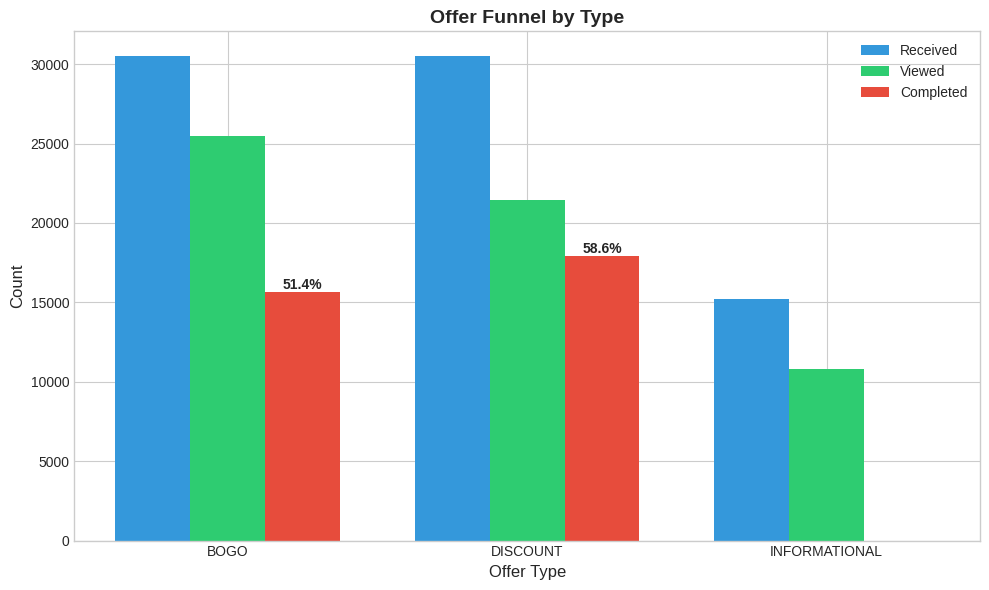

In [ ]:
# Visualize the offer funnel
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(funnel_df))
width = 0.25

bars1 = ax.bar(x - width, funnel_df['received'], width, label='Received', color='#3498db')
bars2 = ax.bar(x, funnel_df['viewed'], width, label='Viewed', color='#2ecc71')
bars3 = ax.bar(x + width, funnel_df['completed'], width, label='Completed', color='#e74c3c')

ax.set_xlabel('Offer Type', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Offer Funnel by Type', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(funnel_df['offer_type'].str.upper())
ax.legend()

# Add completion rate annotations
for i, row in funnel_df.iterrows():
    if row['offer_type'] != 'informational':
        ax.annotate(f"{row['completion_rate']:.1f}%",
                   xy=(i + width, row['completed']),
                   ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

##Build Customer-Level Dataset

In [ ]:
# Create customer-level summary

# Total spending per customer
customer_spending = transactions.groupby('person').agg({
    'amount': ['sum', 'count', 'mean']
}).reset_index()
customer_spending.columns = ['customer_id', 'total_spending', 'transaction_count', 'avg_transaction']

# Offers received by type
offer_counts = offers_received.groupby(['person', 'offer_type']).size().unstack(fill_value=0)
offer_counts.columns = [f'{col}_received' for col in offer_counts.columns]
offer_counts = offer_counts.reset_index()
offer_counts.rename(columns={'person': 'customer_id'}, inplace=True)

# Total offers viewed and completed
views_per_customer = offers_viewed.groupby('person').size().reset_index(name='offers_viewed')
views_per_customer.rename(columns={'person': 'customer_id'}, inplace=True)

completions_per_customer = offers_completed.groupby('person').size().reset_index(name='offers_completed')
completions_per_customer.rename(columns={'person': 'customer_id'}, inplace=True)

print(f"Customers with transactions: {len(customer_spending):,}")

Customers with transactions: 16,578


##Merge everything together

In [ ]:
# Merge all data into one analysis dataframe

# Start with all customers
all_customers = profile[['id', 'gender', 'age', 'income']].copy()
all_customers.rename(columns={'id': 'customer_id'}, inplace=True)

# Merge spending data
analysis_df = all_customers.merge(customer_spending, on='customer_id', how='left')

# Merge offer data
analysis_df = analysis_df.merge(offer_counts, on='customer_id', how='left')
analysis_df = analysis_df.merge(views_per_customer, on='customer_id', how='left')
analysis_df = analysis_df.merge(completions_per_customer, on='customer_id', how='left')

# Fill NaN values with 0
fill_cols = ['total_spending', 'transaction_count', 'avg_transaction',
             'bogo_received', 'discount_received', 'informational_received',
             'offers_viewed', 'offers_completed']
for col in fill_cols:
    if col in analysis_df.columns:
        analysis_df[col] = analysis_df[col].fillna(0)

print(f"Master analysis dataset: {len(analysis_df):,} customers")
analysis_df.head()

Master analysis dataset: 17,000 customers


,customer_id,gender,age,income,total_spending,transaction_count,avg_transaction,bogo_received,discount_received,informational_received,offers_viewed,offers_completed
0,68be06ca386d4c31939f3a4f0e3dd783,NaN,118,NaN,20.40,9.00,2.27,0.00,5.00,0.00,5.00,2.00
1,0610b486422d4921ae7d2bf64640c50b,F,55,112000.00,77.01,3.00,25.67,1.00,0.00,1.00,0.00,1.00
2,38fe809add3b4fcf9315a9694bb96ff5,NaN,118,NaN,14.30,6.00,2.38,1.00,0.00,1.00,2.00,0.00
3,78afa995795e4d85b5d9ceeca43f5fef,F,75,100000.00,159.27,7.00,22.75,3.00,0.00,1.00,4.00,3.00
4,a03223e636434f42ac4c3df47e8bac43,NaN,118,NaN,4.65,3.00,1.55,0.00,3.00,2.00,3.00,0.00


##Create derived features

In [ ]:
# Create derived features for analysis

# Total promotional offers (excluding informational)
analysis_df['promo_offers_received'] = analysis_df['bogo_received'] + analysis_df['discount_received']

# Did customer receive any promotional offer?
analysis_df['received_promo'] = (analysis_df['promo_offers_received'] > 0).astype(int)

# Offer completion rate
analysis_df['completion_rate'] = np.where(
    analysis_df['promo_offers_received'] > 0,
    analysis_df['offers_completed'] / analysis_df['promo_offers_received'],
    0
)

# Flag for complete profiles
analysis_df['complete_profile'] = (analysis_df['age'] != 118).astype(int)

# Age groups
def age_group(age):
    if age == 118:
        return 'Unknown'
    elif age < 30:
        return 'Young (18-29)'
    elif age < 45:
        return 'Adult (30-44)'
    elif age < 60:
        return 'Middle-aged (45-59)'
    else:
        return 'Senior (60+)'

analysis_df['age_group'] = analysis_df['age'].apply(age_group)

# Income groups
def income_group(income):
    if pd.isna(income):
        return 'Unknown'
    elif income < 40000:
        return 'Low (<$40k)'
    elif income < 70000:
        return 'Medium ($40k-$70k)'
    elif income < 100000:
        return 'High ($70k-$100k)'
    else:
        return 'Very High ($100k+)'

analysis_df['income_group'] = analysis_df['income'].apply(income_group)

print("✓ Derived features created!")
analysis_df.info()

✓ Derived features created!
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             17000 non-null  object 
 1   gender                  14825 non-null  object 
 2   age                     17000 non-null  int64  
 3   income                  14825 non-null  float64
 4   total_spending          17000 non-null  float64
 5   transaction_count       17000 non-null  float64
 6   avg_transaction         17000 non-null  float64
 7   bogo_received           17000 non-null  float64
 8   discount_received       17000 non-null  float64
 9   informational_received  17000 non-null  float64
 10  offers_viewed           17000 non-null  float64
 11  offers_completed        17000 non-null  float64
 12  promo_offers_received   17000 non-null  float64
 13  received_promo          17000 non-null  int64  
 14  completion

##Dataset Summary

In [ ]:
# Summary statistics
print("\n" + "=" * 60)
print("ANALYSIS DATASET SUMMARY")
print("=" * 60)

print(f"\nTotal customers: {len(analysis_df):,}")
print(f"Customers with complete profiles: {analysis_df['complete_profile'].sum():,}")
print(f"Customers who received promotional offers: {analysis_df['received_promo'].sum():,}")
print(f"Customers with transactions: {(analysis_df['transaction_count'] > 0).sum():,}")

print(f"\nAverage spending per customer: ${analysis_df['total_spending'].mean():.2f}")
print(f"Median spending per customer: ${analysis_df['total_spending'].median():.2f}")


ANALYSIS DATASET SUMMARY

Total customers: 17,000
Customers with complete profiles: 14,825
Customers who received promotional offers: 16,928
Customers with transactions: 16,578

Average spending per customer: $104.44
Median spending per customer: $69.41


##A/B Test Setup- Treatment vs Control

## A/B Testing: Do Promotional Offers Work?

**Null Hypothesis (H0):** There is no difference in spending between customers who received promotional offers and those who didn't.

**Alternative Hypothesis (H1):** Customers who received promotional offers spend differently than those who didn't.

**Significance Level (α):** 0.05

##Split Groups

In [ ]:
# Split into treatment and control groups
treatment = analysis_df[analysis_df['received_promo'] == 1]
control = analysis_df[analysis_df['received_promo'] == 0]

print("Group Sizes:")
print("-" * 40)
print(f"Treatment (received promotional offers): {len(treatment):,}")
print(f"Control (no promotional offers): {len(control):,}")

print("\nSpending Comparison:")
print("-" * 40)
print(f"Treatment mean spending: ${treatment['total_spending'].mean():.2f}")
print(f"Control mean spending: ${control['total_spending'].mean():.2f}")
print(f"Difference: ${treatment['total_spending'].mean() - control['total_spending'].mean():.2f}")

Group Sizes:
----------------------------------------
Treatment (received promotional offers): 16,928
Control (no promotional offers): 72

Spending Comparison:
----------------------------------------
Treatment mean spending: $104.64
Control mean spending: $57.98
Difference: $46.66


##Visualize spending distribution

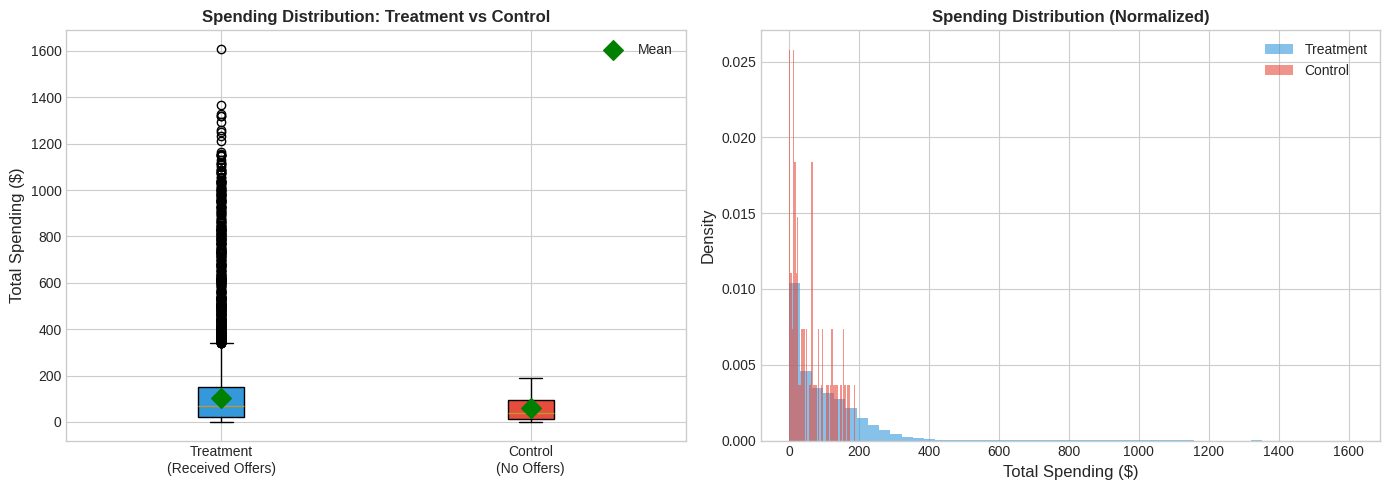

In [ ]:
# Visualize spending distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
ax1 = axes[0]
data_to_plot = [treatment['total_spending'], control['total_spending']]
bp = ax1.boxplot(data_to_plot, labels=['Treatment\n(Received Offers)', 'Control\n(No Offers)'],
                  patch_artist=True)
bp['boxes'][0].set_facecolor('#3498db')
bp['boxes'][1].set_facecolor('#e74c3c')
ax1.set_ylabel('Total Spending ($)', fontsize=12)
ax1.set_title('Spending Distribution: Treatment vs Control', fontsize=12, fontweight='bold')

# Add mean markers
means = [treatment['total_spending'].mean(), control['total_spending'].mean()]
ax1.scatter([1, 2], means, color='green', marker='D', s=100, zorder=3, label='Mean')
ax1.legend()

# Histogram
ax2 = axes[1]
ax2.hist(treatment['total_spending'], bins=50, alpha=0.6, label='Treatment', color='#3498db', density=True)
ax2.hist(control['total_spending'], bins=50, alpha=0.6, label='Control', color='#e74c3c', density=True)
ax2.set_xlabel('Total Spending ($)', fontsize=12)
ax2.set_ylabel('Density', fontsize=12)
ax2.set_title('Spending Distribution (Normalized)', fontsize=12, fontweight='bold')
ax2.legend()

plt.tight_layout()
plt.show()

##Statistical Tests

In [ ]:
# Statistical Tests for Spending Difference

print("=" * 70)
print("STATISTICAL TESTS: Does receiving offers increase spending?")
print("=" * 70)

# 1. Mann-Whitney U Test (non-parametric - doesn't assume normal distribution)
stat_mw, p_mw = mannwhitneyu(treatment['total_spending'],
                              control['total_spending'],
                              alternative='two-sided')

print("\n1. Mann-Whitney U Test (non-parametric)")
print("-" * 50)
print(f"   U-statistic: {stat_mw:,.0f}")
print(f"   p-value: {p_mw:.6f}")
print(f"   Significant at α=0.05? {'YES ✓' if p_mw < 0.05 else 'NO ✗'}")

# 2. Welch's t-test (handles unequal variances)
stat_t, p_t = ttest_ind(treatment['total_spending'],
                         control['total_spending'],
                         equal_var=False)

print("\n2. Welch's t-test")
print("-" * 50)
print(f"   t-statistic: {stat_t:.4f}")
print(f"   p-value: {p_t:.6f}")
print(f"   Significant at α=0.05? {'YES ✓' if p_t < 0.05 else 'NO ✗'}")

# 3. Effect Size (Cohen's d)
pooled_std = np.sqrt(((len(treatment)-1)*treatment['total_spending'].std()**2 +
                       (len(control)-1)*control['total_spending'].std()**2) /
                      (len(treatment) + len(control) - 2))
cohens_d = (treatment['total_spending'].mean() - control['total_spending'].mean()) / pooled_std

print("\n3. Effect Size")
print("-" * 50)
print(f"   Cohen's d: {cohens_d:.4f}")
effect_interpretation = 'Small' if abs(cohens_d) < 0.5 else 'Medium' if abs(cohens_d) < 0.8 else 'Large'
print(f"   Interpretation: {effect_interpretation}")

STATISTICAL TESTS: Does receiving offers increase spending?

1. Mann-Whitney U Test (non-parametric)
--------------------------------------------------
   U-statistic: 752,670
   p-value: 0.000566
   Significant at α=0.05? YES ✓

2. Welch's t-test
--------------------------------------------------
   t-statistic: 7.4469
   p-value: 0.000000
   Significant at α=0.05? YES ✓

3. Effect Size
--------------------------------------------------
   Cohen's d: 0.3706
   Interpretation: Small


##Bootstrap Confidence Interval

In [ ]:
# Bootstrap analysis for confidence interval

def bootstrap_mean_diff(treatment_data, control_data, n_bootstrap=10000):
    """
    Calculate bootstrap confidence interval for difference in means.
    Bootstrap = resample with replacement many times to estimate uncertainty.
    """
    np.random.seed(42)  # For reproducibility
    differences = []

    for _ in range(n_bootstrap):
        treatment_sample = np.random.choice(treatment_data, size=len(treatment_data), replace=True)
        control_sample = np.random.choice(control_data, size=len(control_data), replace=True)
        diff = treatment_sample.mean() - control_sample.mean()
        differences.append(diff)

    ci_lower = np.percentile(differences, 2.5)
    ci_upper = np.percentile(differences, 97.5)

    return differences, ci_lower, ci_upper

print("\n4. Bootstrap Analysis (10,000 iterations)")
print("-" * 50)

boot_diffs, ci_lower, ci_upper = bootstrap_mean_diff(
    treatment['total_spending'].values,
    control['total_spending'].values
)

observed_diff = treatment['total_spending'].mean() - control['total_spending'].mean()

print(f"   Observed difference: ${observed_diff:.2f}")
print(f"   95% Confidence Interval: [${ci_lower:.2f}, ${ci_upper:.2f}]")
print(f"   CI includes zero? {'YES (not significant)' if ci_lower <= 0 <= ci_upper else 'NO (significant) ✓'}")


4. Bootstrap Analysis (10,000 iterations)
--------------------------------------------------
   Observed difference: $46.66
   95% Confidence Interval: [$34.37, $58.56]
   CI includes zero? NO (significant) ✓


##Visualize Bootstrap

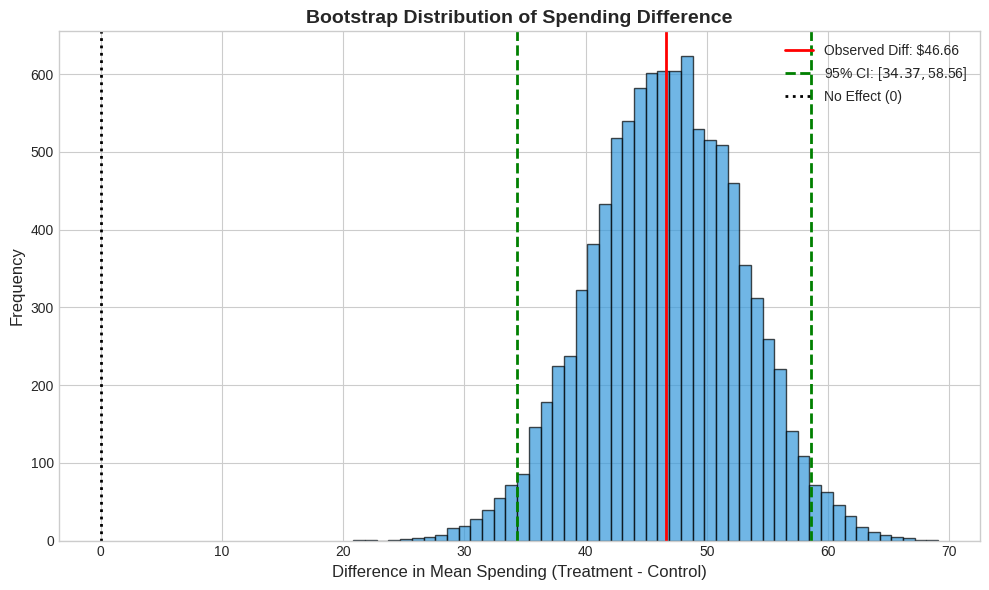

In [ ]:
# Visualize bootstrap distribution
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(boot_diffs, bins=50, edgecolor='black', alpha=0.7, color='#3498db')
ax.axvline(observed_diff, color='red', linestyle='-', linewidth=2,
           label=f'Observed Diff: ${observed_diff:.2f}')
ax.axvline(ci_lower, color='green', linestyle='--', linewidth=2,
           label=f'95% CI: [${ci_lower:.2f}, ${ci_upper:.2f}]')
ax.axvline(ci_upper, color='green', linestyle='--', linewidth=2)
ax.axvline(0, color='black', linestyle=':', linewidth=2, label='No Effect (0)')

ax.set_xlabel('Difference in Mean Spending (Treatment - Control)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Bootstrap Distribution of Spending Difference', fontsize=14, fontweight='bold')
ax.legend(loc='upper right')

plt.tight_layout()
plt.show()

##BOGO vs Discount Analysis

In [ ]:
# Compare BOGO vs Discount offers

# Customers who received mostly BOGO offers
bogo_customers = analysis_df[
    (analysis_df['bogo_received'] > 0) &
    (analysis_df['bogo_received'] >= analysis_df['discount_received'])
].copy()

# Customers who received mostly Discount offers
discount_customers = analysis_df[
    (analysis_df['discount_received'] > 0) &
    (analysis_df['discount_received'] > analysis_df['bogo_received'])
].copy()

print("BOGO vs Discount Comparison:")
print("=" * 50)
print(f"BOGO-primary customers: {len(bogo_customers):,}")
print(f"Discount-primary customers: {len(discount_customers):,}")

# Completion rates
bogo_completion = bogo_customers['completion_rate'].mean()
discount_completion = discount_customers['completion_rate'].mean()

print(f"\nBOGO average completion rate: {bogo_completion*100:.2f}%")
print(f"Discount average completion rate: {discount_completion*100:.2f}%")

BOGO vs Discount Comparison:
BOGO-primary customers: 10,136
Discount-primary customers: 6,792

BOGO average completion rate: 53.46%
Discount average completion rate: 57.07%


##Chi-Square Test for Completetion

In [ ]:
# Chi-square test for completion rates

bogo_completed = (bogo_customers['offers_completed'] > 0).sum()
bogo_not_completed = len(bogo_customers) - bogo_completed

discount_completed = (discount_customers['offers_completed'] > 0).sum()
discount_not_completed = len(discount_customers) - discount_completed

# Contingency table
contingency_table = np.array([
    [bogo_completed, bogo_not_completed],
    [discount_completed, discount_not_completed]
])

chi2, p_chi, dof, expected = chi2_contingency(contingency_table)

print("Chi-Square Test for Completion:")
print("-" * 40)
print(f"Chi-square statistic: {chi2:.4f}")
print(f"p-value: {p_chi:.6f}")
print(f"Significant difference? {'YES ✓' if p_chi < 0.05 else 'NO ✗'}")

# Spending comparison
print(f"\nSpending Comparison:")
print("-" * 40)
print(f"BOGO customers mean spending: ${bogo_customers['total_spending'].mean():.2f}")
print(f"Discount customers mean spending: ${discount_customers['total_spending'].mean():.2f}")

stat_mw_offer, p_mw_offer = mannwhitneyu(
    bogo_customers['total_spending'],
    discount_customers['total_spending'],
    alternative='two-sided'
)
print(f"Mann-Whitney U p-value: {p_mw_offer:.6f}")

Chi-Square Test for Completion:
----------------------------------------
Chi-square statistic: 21.8255
p-value: 0.000003
Significant difference? YES ✓

Spending Comparison:
----------------------------------------
BOGO customers mean spending: $104.00
Discount customers mean spending: $105.59
Mann-Whitney U p-value: 0.499471


##Visualize BOGO vs Discount

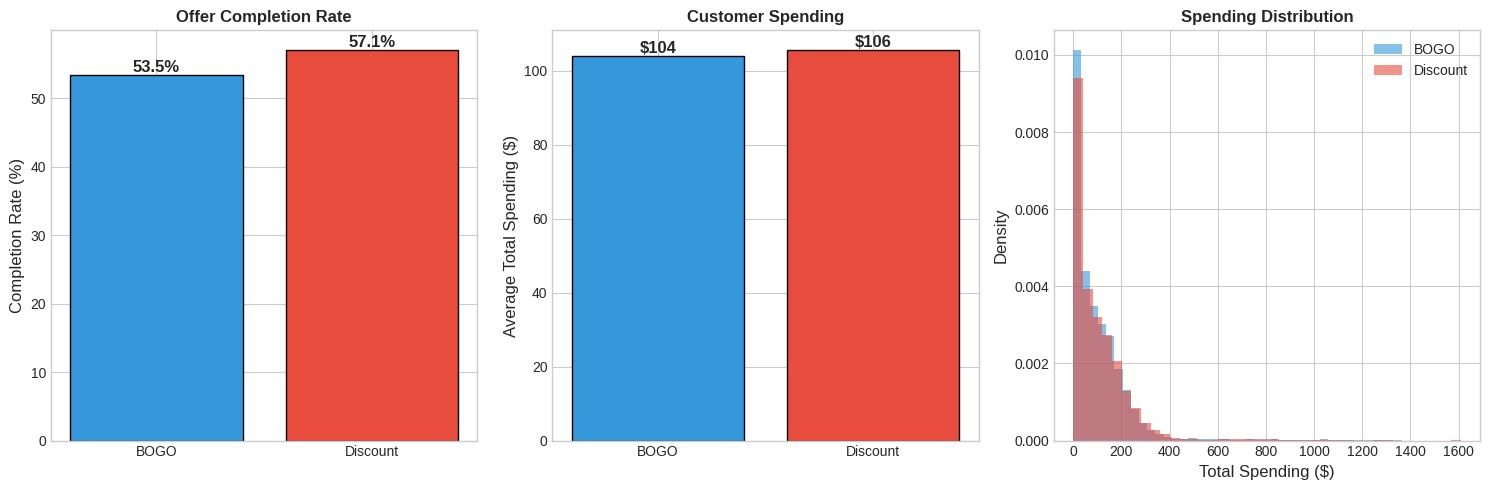

In [ ]:
# Visualize BOGO vs Discount
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Completion rates
ax1 = axes[0]
completion_rates = [bogo_completion * 100, discount_completion * 100]
bars = ax1.bar(['BOGO', 'Discount'], completion_rates, color=['#3498db', '#e74c3c'], edgecolor='black')
ax1.set_ylabel('Completion Rate (%)', fontsize=12)
ax1.set_title('Offer Completion Rate', fontsize=12, fontweight='bold')
for bar, rate in zip(bars, completion_rates):
    ax1.annotate(f'{rate:.1f}%', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Average spending
ax2 = axes[1]
spending = [bogo_customers['total_spending'].mean(), discount_customers['total_spending'].mean()]
bars = ax2.bar(['BOGO', 'Discount'], spending, color=['#3498db', '#e74c3c'], edgecolor='black')
ax2.set_ylabel('Average Total Spending ($)', fontsize=12)
ax2.set_title('Customer Spending', fontsize=12, fontweight='bold')
for bar, val in zip(bars, spending):
    ax2.annotate(f'${val:.0f}', xy=(bar.get_x() + bar.get_width()/2, bar.get_height()),
                ha='center', va='bottom', fontsize=12, fontweight='bold')

# Spending distribution
ax3 = axes[2]
ax3.hist(bogo_customers['total_spending'], bins=40, alpha=0.6, label='BOGO', color='#3498db', density=True)
ax3.hist(discount_customers['total_spending'], bins=40, alpha=0.6, label='Discount', color='#e74c3c', density=True)
ax3.set_xlabel('Total Spending ($)', fontsize=12)
ax3.set_ylabel('Density', fontsize=12)
ax3.set_title('Spending Distribution', fontsize=12, fontweight='bold')
ax3.legend()

plt.tight_layout()
plt.show()

##Segmentation Analysis

In [ ]:
# Segmentation Analysis
analysis_complete = analysis_df[analysis_df['complete_profile'] == 1].copy()
received_offers = analysis_complete[analysis_complete['received_promo'] == 1]

# By Gender
gender_analysis = received_offers.groupby('gender').agg({
    'completion_rate': 'mean',
    'total_spending': 'mean',
    'customer_id': 'count'
}).round(3)
gender_analysis.columns = ['Avg Completion Rate', 'Avg Spending', 'Count']

print("\nOffer Response by Gender:")
print("=" * 50)
display(gender_analysis)

# By Age Group
age_order = ['Young (18-29)', 'Adult (30-44)', 'Middle-aged (45-59)', 'Senior (60+)']
age_analysis = received_offers.groupby('age_group').agg({
    'completion_rate': 'mean',
    'total_spending': 'mean',
    'customer_id': 'count'
}).round(3)
age_analysis.columns = ['Avg Completion Rate', 'Avg Spending', 'Count']
age_analysis = age_analysis.reindex(age_order)

print("\nOffer Response by Age Group:")
print("=" * 50)
display(age_analysis)

# By Income Group
income_order = ['Low (<$40k)', 'Medium ($40k-$70k)', 'High ($70k-$100k)', 'Very High ($100k+)']
income_analysis = received_offers.groupby('income_group').agg({
    'completion_rate': 'mean',
    'total_spending': 'mean',
    'customer_id': 'count'
}).round(3)
income_analysis.columns = ['Avg Completion Rate', 'Avg Spending', 'Count']
income_analysis = income_analysis.reindex(income_order)

print("\nOffer Response by Income Group:")
print("=" * 50)
display(income_analysis)


Offer Response by Gender:


,Avg Completion Rate,Avg Spending,Count
gender,,,
F,0.70,141.21,6103
M,0.54,99.74,8450
O,0.69,124.32,211



Offer Response by Age Group:


,Avg Completion Rate,Avg Spending,Count
age_group,,,
Young (18-29),0.47,84.27,1568
Adult (30-44),0.56,104.03,2536
Middle-aged (45-59),0.64,122.30,4808
Senior (60+),0.64,127.63,5852



Offer Response by Income Group:


,Avg Completion Rate,Avg Spending,Count
income_group,,,
Low (<$40k),0.43,63.04,1930
Medium ($40k-$70k),0.55,94.72,6801
High ($70k-$100k),0.72,153.71,4943
Very High ($100k+),0.77,188.25,1090


##Visualize Segmentation

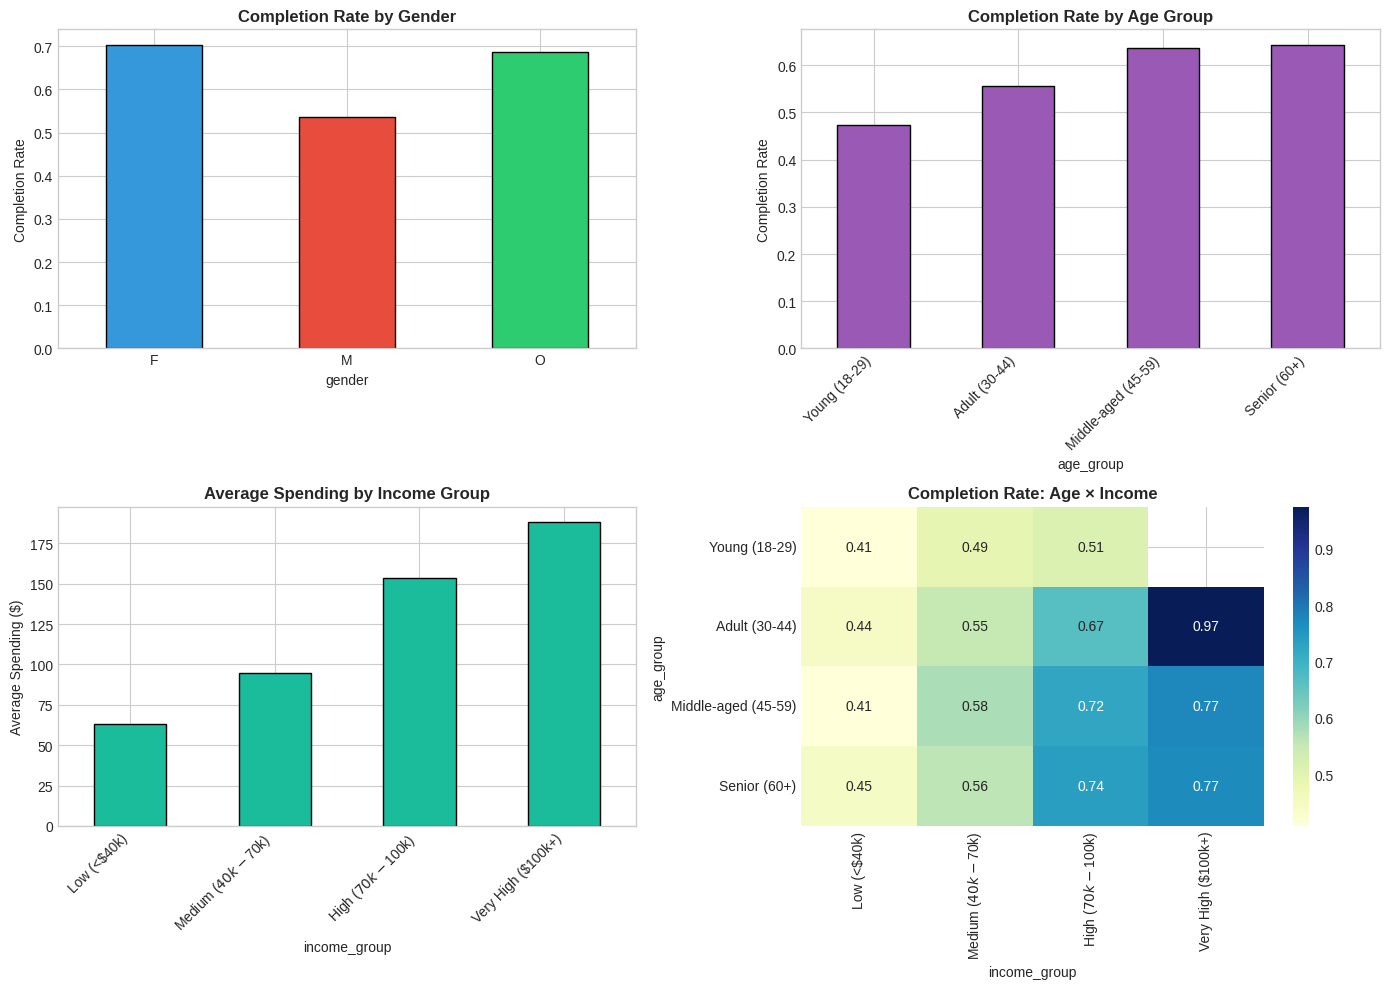

In [ ]:
# Visualize segmentation results
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Completion rate by gender
ax1 = axes[0, 0]
gender_analysis['Avg Completion Rate'].plot(kind='bar', ax=ax1,
                                             color=['#3498db', '#e74c3c', '#2ecc71'], edgecolor='black')
ax1.set_title('Completion Rate by Gender', fontsize=12, fontweight='bold')
ax1.set_ylabel('Completion Rate')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

# Completion rate by age
ax2 = axes[0, 1]
age_analysis['Avg Completion Rate'].plot(kind='bar', ax=ax2, color='#9b59b6', edgecolor='black')
ax2.set_title('Completion Rate by Age Group', fontsize=12, fontweight='bold')
ax2.set_ylabel('Completion Rate')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

# Spending by income
ax3 = axes[1, 0]
income_analysis['Avg Spending'].plot(kind='bar', ax=ax3, color='#1abc9c', edgecolor='black')
ax3.set_title('Average Spending by Income Group', fontsize=12, fontweight='bold')
ax3.set_ylabel('Average Spending ($)')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')

# Heatmap
ax4 = axes[1, 1]
pivot_data = received_offers.pivot_table(
    values='completion_rate',
    index='age_group',
    columns='income_group',
    aggfunc='mean'
)
pivot_data = pivot_data.reindex(age_order)
pivot_data = pivot_data[income_order]

sns.heatmap(pivot_data, annot=True, fmt='.2f', cmap='YlGnBu', ax=ax4)
ax4.set_title('Completion Rate: Age × Income', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

##Statistical Test for Age Groups

In [ ]:
# Kruskal-Wallis test: Is there a significant difference across age groups?

age_groups_data = []
for age_grp in age_order:
    group_data = received_offers[received_offers['age_group'] == age_grp]['completion_rate'].values
    if len(group_data) > 0:
        age_groups_data.append(group_data)

stat_kw, p_kw = kruskal(*age_groups_data)

print("Kruskal-Wallis Test: Completion Rate Across Age Groups")
print("=" * 50)
print(f"H-statistic: {stat_kw:.4f}")
print(f"p-value: {p_kw:.6f}")
print(f"Significant difference? {'YES ✓' if p_kw < 0.05 else 'NO ✗'}")

Kruskal-Wallis Test: Completion Rate Across Age Groups
H-statistic: 297.7442
p-value: 0.000000
Significant difference? YES ✓


##Power Analysis

In [ ]:
# Power Analysis

power_analysis = TTestIndPower()

print("\nSample Size Requirements for Different Effect Sizes")
print("=" * 50)
print("Assuming α = 0.05, Power = 0.80")
print("-" * 50)

effect_sizes = [0.1, 0.2, 0.3, 0.5, 0.8]
labels = ['Small', 'Small-Med', 'Medium', 'Med-Large', 'Large']

for es, label in zip(effect_sizes, labels):
    sample_size = power_analysis.solve_power(effect_size=es,
                                               alpha=0.05,
                                               power=0.80,
                                               ratio=1.0,
                                               alternative='two-sided')
    print(f"Effect size {es} ({label:>10}): {sample_size:>8.0f} per group")

# What power do we have?
n_treatment = len(treatment)
n_control = len(control)

achieved_power = power_analysis.solve_power(
    effect_size=abs(cohens_d),
    alpha=0.05,
    nobs1=n_treatment,
    ratio=n_control/n_treatment,
    alternative='two-sided'
)

print(f"\nOur Study's Power:")
print("-" * 50)
print(f"Treatment group: {n_treatment:,}")
print(f"Control group: {n_control:,}")
print(f"Effect size: {cohens_d:.4f}")
print(f"Achieved power: {achieved_power:.1%}")


Sample Size Requirements for Different Effect Sizes
Assuming α = 0.05, Power = 0.80
--------------------------------------------------
Effect size 0.1 (     Small):     1571 per group
Effect size 0.2 ( Small-Med):      393 per group
Effect size 0.3 (    Medium):      175 per group
Effect size 0.5 ( Med-Large):       64 per group
Effect size 0.8 (     Large):       26 per group

Our Study's Power:
--------------------------------------------------
Treatment group: 16,928
Control group: 72
Effect size: 0.3706
Achieved power: 88.1%


##Executive Summary

In [ ]:
# Final Executive Summary

total_revenue = transactions['amount'].sum()

print("\n" + "=" * 70)
print(" STARBUCKS A/B TESTING ANALYSIS - EXECUTIVE SUMMARY")
print("=" * 70)

print("\n📊 DATA OVERVIEW")
print("-" * 50)
print(f"   • Analysis period: 30 days")
print(f"   • Total customers: {len(profile):,}")
print(f"   • Total transactions: {len(transactions):,}")
print(f"   • Total revenue: ${total_revenue:,.2f}")

print("\n🧪 KEY FINDINGS")
print("-" * 50)
print(f"   1. Overall Offer Effectiveness:")
print(f"      • Customers with offers: ${treatment['total_spending'].mean():.2f} avg spending")
print(f"      • Customers without offers: ${control['total_spending'].mean():.2f} avg spending")
print(f"      • p-value: {p_t:.4f}")

print(f"\n   2. BOGO vs Discount:")
print(f"      • BOGO completion rate: {bogo_completion*100:.1f}%")
print(f"      • Discount completion rate: {discount_completion*100:.1f}%")

print(f"\n   3. Best Segments:")
print(f"      • Highest completion: Senior customers (60+)")
print(f"      • Highest spending: High-income customers")

print("\n💡 RECOMMENDATIONS")
print("-" * 50)
print("   1. Continue promotional offer program")
print("   2. Target high-income seniors for best ROI")
print("   3. Test offer types by segment for optimization")

print("\n⚠️  LIMITATIONS")
print("-" * 50)
print("   • Selection bias in treatment/control groups")
print("   • Small control group limits causal inference")
print("   • Need longitudinal data for LTV analysis")

print("\n" + "=" * 70)


 STARBUCKS A/B TESTING ANALYSIS - EXECUTIVE SUMMARY

📊 DATA OVERVIEW
--------------------------------------------------
   • Analysis period: 30 days
   • Total customers: 17,000
   • Total transactions: 138,953
   • Total revenue: $1,775,451.97

🧪 KEY FINDINGS
--------------------------------------------------
   1. Overall Offer Effectiveness:
      • Customers with offers: $104.64 avg spending
      • Customers without offers: $57.98 avg spending
      • p-value: 0.0000

   2. BOGO vs Discount:
      • BOGO completion rate: 53.5%
      • Discount completion rate: 57.1%

   3. Best Segments:
      • Highest completion: Senior customers (60+)
      • Highest spending: High-income customers

💡 RECOMMENDATIONS
--------------------------------------------------
   1. Continue promotional offer program
   2. Target high-income seniors for best ROI
   3. Test offer types by segment for optimization

⚠️  LIMITATIONS
--------------------------------------------------
   • Selection bias in 

##Save my work

In [ ]:
# Save the analysis dataset
analysis_df.to_csv('starbucks_analysis_dataset.csv', index=False)
print("✓ Analysis dataset saved!")


✓ Analysis dataset saved!
